In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.integrate import simpson

In [2]:
from constants import hbar_meV_ps as hbar, me as m

In [3]:
omega = 1 / hbar

m_c = tf.cast(m, tf.complex64)
hbar_c = tf.cast(hbar, tf.complex64)
omega_c = tf.cast(omega, tf.complex64)

x_min = -100 # nm
x_max = 100 # nm
t_min = 0 # ps
t_max = 50 # ps

# PINN

In [4]:
class PINN(tf.keras.Model):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = [tf.keras.layers.Dense(units, activation="tanh", ) for units in layers[1:-1]]
    self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

  def call(self, inputs):
    x, t = inputs
    X = tf.stack([x, t], axis=1)

    for layer in self.hidden_layers:
      X = layer(X)

    output = self.output_layer(X)
    psi_real = output[:, 0]
    psi_imag = output[:, 1]
    return psi_real, psi_imag

In [5]:
layers = [2, 64, 128, 128, 64, 2]

In [6]:
n_collocation = 25000
n_initial = 8000
n_boundary = 3000

x_collocation = np.random.uniform(x_min, x_max, n_collocation)
t_collocation = np.random.uniform(t_min, t_max, n_collocation)

x_initial = np.random.uniform(x_min, x_max, n_initial)
t_initial = np.full(n_initial, t_min)

x_boundary = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
t_boundary = np.random.uniform(t_min, t_max, n_boundary)

In [7]:
# def normalize(value, min_value, max_value):
#   return ((value - min_value) / (max_value - min_value))

In [8]:
# x_collocation = normalize(x_collocation, x_min, x_max)
# t_collocation = normalize(t_collocation, t_min, t_max)

# x_initial = normalize(x_initial, x_min, x_max)
# t_initial =  normalize(t_initial, t_min, t_max)

# x_boundary = normalize(x_boundary, x_min, x_max)
# t_boundary = normalize(t_boundary, t_min, t_max)

In [9]:
x_collocation_tf = tf.convert_to_tensor(x_collocation, dtype=tf.float64)
t_collocation_tf = tf.convert_to_tensor(t_collocation, dtype=tf.float64)

x_initial_tf = tf.convert_to_tensor(x_initial, dtype=tf.float64)
t_initial_tf = tf.convert_to_tensor(t_initial, dtype=tf.float64)

x_boundary_tf = tf.convert_to_tensor(x_boundary, dtype=tf.float64)
t_boundary_tf = tf.convert_to_tensor(t_boundary, dtype=tf.float64)

In [10]:
# x_collocation_tf = normalize(x_collocation_tf, x_min, x_max)
# t_collocation_tf = normalize(t_collocation_tf, t_min, t_max)

# x_initial_tf = normalize(x_initial_tf, x_min, x_max)
# t_initial_tf =  normalize(t_initial_tf, t_min, t_max)

# x_boundary_tf = normalize(x_boundary_tf, x_min, x_max)
# t_boundary_tf = normalize(t_boundary_tf, t_min, t_max)

In [11]:
learning_exp = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=1000,
  decay_rate=0.9
)

learning_piece = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
  [200, 400, 600], [0.01, 0.001, 0.0005, 0.0001]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_exp)

In [12]:
model = PINN(layers)

In [13]:
@tf.function
def loss_function():
  #pde loss
  with tf.GradientTape(persistent=True) as tape:
    tape.watch([x_collocation_tf, t_collocation_tf])

    psi_real, psi_img = model((x_collocation_tf, t_collocation_tf))
    psi = tf.complex(psi_real, psi_img)

    d_psi_dx = tape.gradient(psi, x_collocation_tf)
    d_psi_dt = tape.gradient(psi, t_collocation_tf)

  d2_psi_dx2 = tape.gradient(d_psi_dx, x_collocation_tf)

  del tape

  i = tf.complex(0.0, 1.0)
  d_psi_dt = tf.cast(d_psi_dt, tf.complex64)
  d2_psi_dx2 = tf.cast(d2_psi_dx2, tf.complex64)
  
  residual = i * hbar_c * d_psi_dt + ((hbar_c ** 2) / (2 * m_c)) * d2_psi_dx2 - tf.cast(0.5 * m * (omega ** 2) * (x_collocation_tf ** 2), tf.complex64) * psi
  physics_loss = tf.reduce_mean(tf.square(tf.abs(residual)))



  #initial condition loss
  psi_real_initial, psi_img_initial = model((x_initial_tf, t_initial_tf))
  psi_initial = tf.complex(psi_real_initial, psi_img_initial)

  psi_initial_actual = (((m * omega) / (np.pi * hbar)) ** 0.25) * tf.exp(((-m * omega) / (2 * hbar)) * (x_initial_tf ** 2))
  psi_initial_actual = tf.cast(psi_initial_actual, tf.complex64)

  initial_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_initial - psi_initial_actual)))



  #boundary condition loss
  psi_real_boundary, psi_img_boundary = model((x_boundary_tf, t_boundary_tf))
  psi_boundary = tf.complex(psi_real_boundary, psi_img_boundary)
  boundary_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_boundary)))



  #normalization loss
  # psi_2 = psi_real ** 2 + psi_img ** 2
  # normalization_value = simpson(psi_2, x_collocation_tf)
  # normalization_loss = tf.square(normalization_value - 1)
  normalization_loss = 0.0

  return physics_loss, initial_condition_loss, boundary_condition_loss, normalization_loss

In [14]:
epochs = 20000
history = []

for epoch in range(1, epochs+1):
    with tf.GradientTape() as tape:
        physics_loss, initial_condition_loss, boundary_condition_loss, normalization_loss = loss_function()
        total_loss = physics_loss + initial_condition_loss + boundary_condition_loss + normalization_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    del tape

    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    history.append({
        'total_loss': total_loss.numpy(),
        'physics_loss': physics_loss.numpy(),
        'initial_condition_loss': initial_condition_loss.numpy(),
        'boundary_condition_loss': boundary_condition_loss.numpy(),
        'normalization_loss': normalization_loss.numpy()
    })

    if (epoch % 200 == 0):
        print(f"Epoch {epoch}/{epochs}\nTotal Loss: {total_loss.numpy()}\nPhysics Loss: {physics_loss.numpy()}\nInitial Condition Loss: {initial_condition_loss.numpy()}\nBoundary Condition Loss: {boundary_condition_loss.numpy()}\nNormalization Loss: {normalization_loss.numpy()}")
        print("--------------------------------------------------")

Epoch 200/20000
Total Loss: 1.826447606086731
Physics Loss: 1.817591667175293
Initial Condition Loss: 0.006741685792803764
Boundary Condition Loss: 0.0021143320482224226
Normalization Loss: 0.0
--------------------------------------------------
Epoch 400/20000
Total Loss: 1.4106487035751343
Physics Loss: 1.4036784172058105
Initial Condition Loss: 0.005354711320251226
Boundary Condition Loss: 0.0016155041521415114
Normalization Loss: 0.0
--------------------------------------------------
Epoch 600/20000
Total Loss: 7.167788982391357
Physics Loss: 7.148232936859131
Initial Condition Loss: 0.011292245239019394
Boundary Condition Loss: 0.008263434283435345
Normalization Loss: 0.0
--------------------------------------------------
Epoch 800/20000
Total Loss: 0.16507095098495483
Physics Loss: 0.16127640008926392
Initial Condition Loss: 0.003607403952628374
Boundary Condition Loss: 0.0001871379790827632
Normalization Loss: 0.0
--------------------------------------------------
Epoch 1000/2000

In [15]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]
normalization_loss_history = [record['normalization_loss'] for record in history]

epochs_range = range(1, epochs + 1)

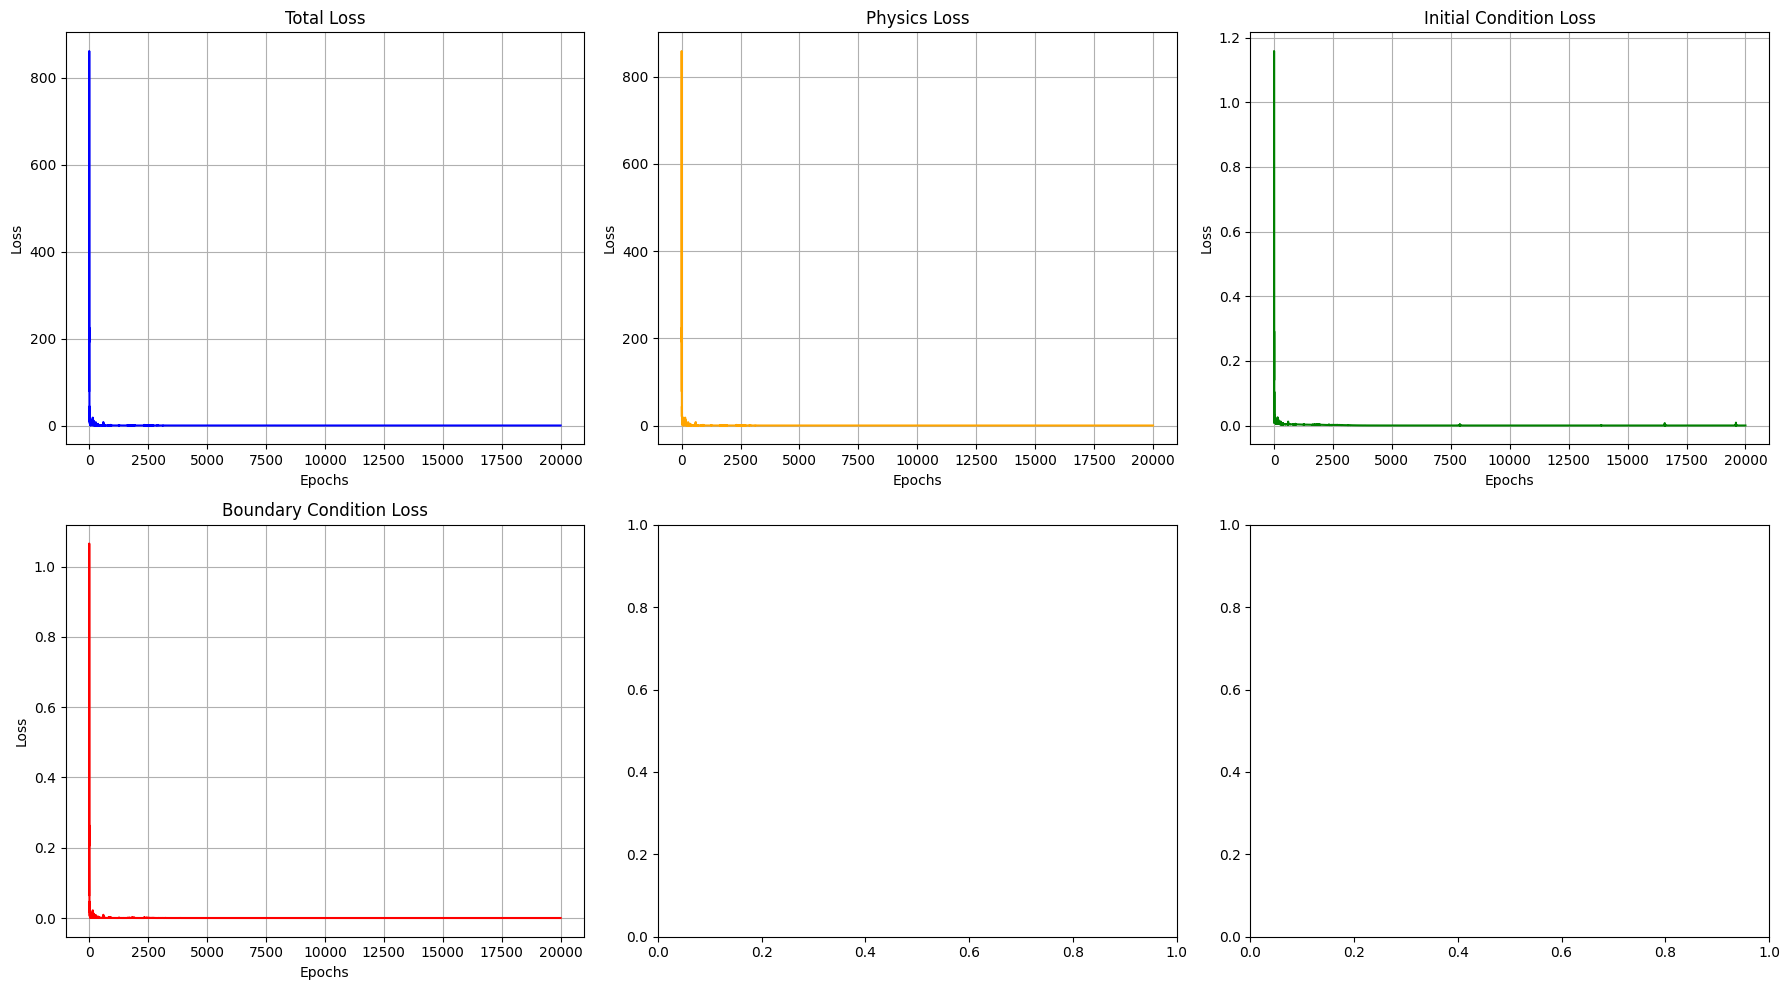

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[0, 2].plot(epochs_range, initial_condition_loss_history, color='green')
axs[0, 2].set_title('Initial Condition Loss')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)

# Boundary Condition Loss
axs[1, 0].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 0].set_title('Boundary Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

#Normalization Loss
# axs[1, 1].plot(epochs_range, normalization_loss_history, color='violet')
# axs[1, 1].set_title('Normalization Loss')
# axs[1, 1].set_xlabel('Epochs')
# axs[1, 1].set_ylabel('Loss')
# axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

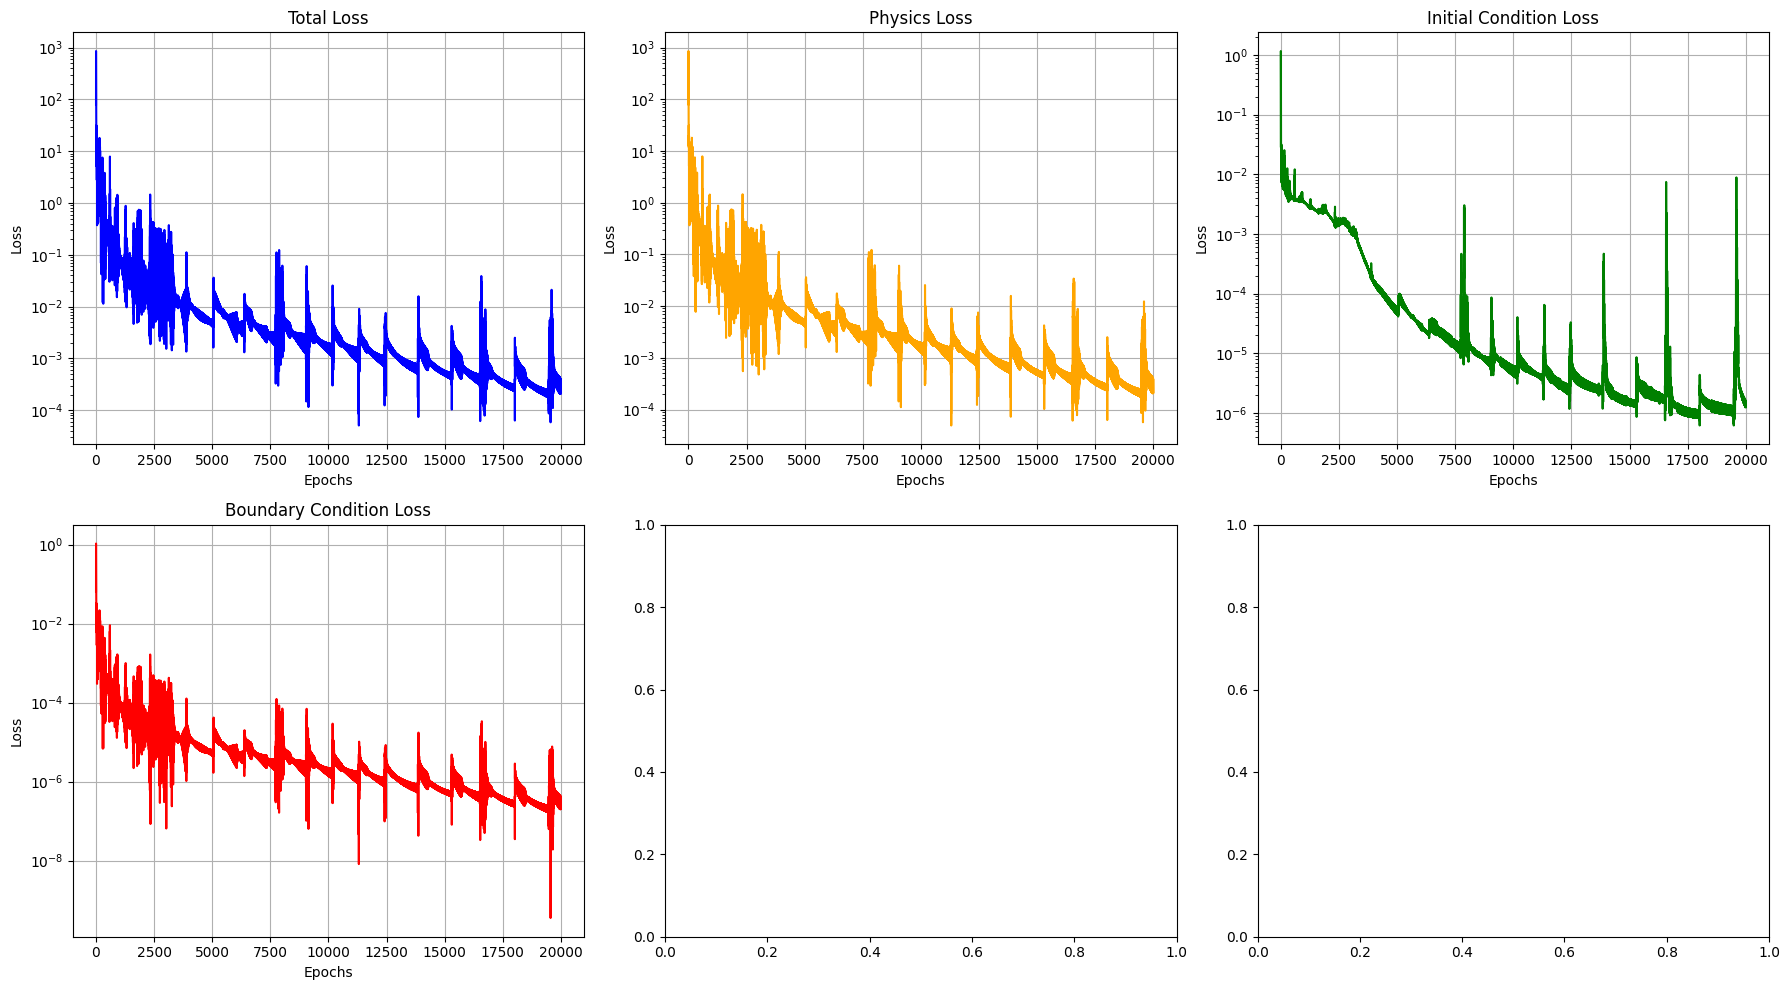

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[0, 2].plot(epochs_range, initial_condition_loss_history, color='green')
axs[0, 2].set_title('Initial Condition Loss')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)
axs[0, 2].set_yscale("log")

# Boundary Condition Loss
axs[1, 0].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 0].set_title('Boundary Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

#Normalization Loss
# axs[1, 1].plot(epochs_range, normalization_loss_history, color='violet')
# axs[1, 1].set_title('Normalization Loss')
# axs[1, 1].set_xlabel('Epochs')
# axs[1, 1].set_ylabel('Loss')
# axs[1, 1].grid(True)
# axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

# Analytical

In [18]:
Nx = 400
Nt = 400

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [19]:
E0 = 0.5 * omega * hbar
A = (m * omega / (np.pi * hbar)) ** 0.25
alpha = (m * omega) / (2.0 * hbar)

# psi(x, t) = psi(x, 0) * exp(-i * (E0 / hbar) * t)
# psi(x, 0) = A * exp(-alpha * x ** 2)

In [20]:
psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values):
  psi0_x = A * np.exp(-alpha * x ** 2)

  for j, t in enumerate(t_values):
    phase = -E0 * t / hbar
    exp_phase = np.exp(1j * phase)

    psi_x_t = psi0_x * exp_phase

    psi_real_analytical[i, j] = np.real(psi_x_t)
    psi_img_analytical[i, j] = np.imag(psi_x_t)

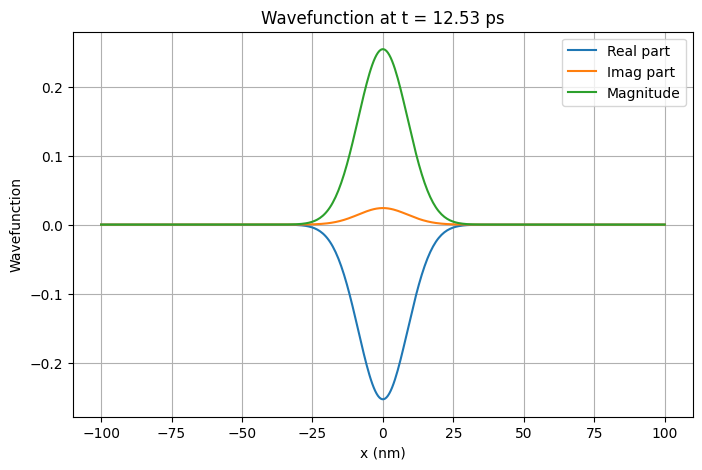

In [21]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

plt.figure(figsize=(8,5))
plt.plot(x_values, psi_real_slice_analytical, label='Real part')
plt.plot(x_values, psi_img_slice_analytical, label='Imag part')
plt.plot(x_values, psi_mag_slice_analytical, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


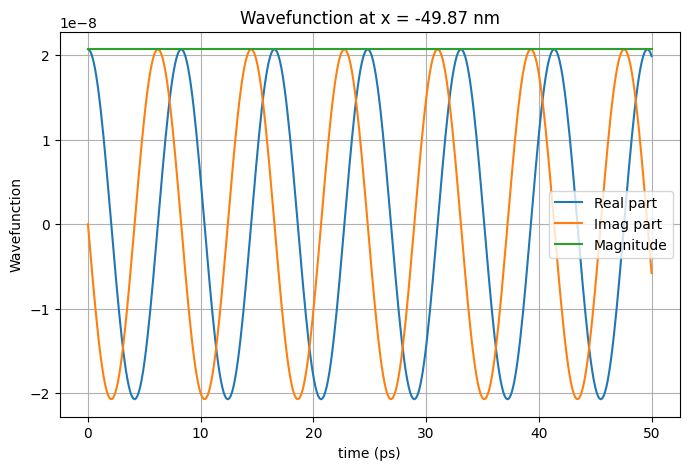

In [22]:
space_index = 100
space_chosen = x_values[space_index]

psi_real_slice_analytical = psi_real_analytical[space_index, :]
psi_img_slice_analytical = psi_img_analytical[space_index, :]

psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

plt.figure(figsize=(8,5))
plt.plot(t_values, psi_real_slice_analytical, label='Real part')
plt.plot(t_values, psi_img_slice_analytical, label='Imag part')
plt.plot(t_values, psi_mag_slice_analytical, label='Magnitude')
plt.title(f'Wavefunction at x = {space_chosen:.2f} nm')
plt.xlabel('time (ps)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


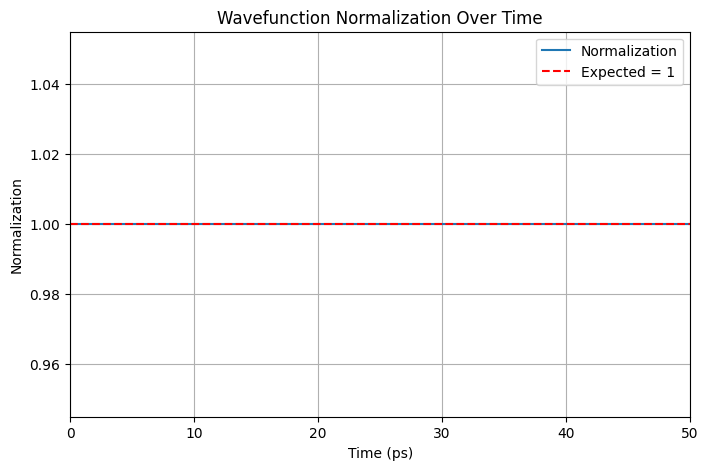

In [23]:
from scipy.integrate import simpson

norms = []

for i in range(400):
  psi_sq = psi_real_analytical[:, i] ** 2 + psi_img_analytical[:, i] ** 2
  normalization = simpson(psi_sq, x_values)
  norms.append(normalization)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlim(0, 50)
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.show()

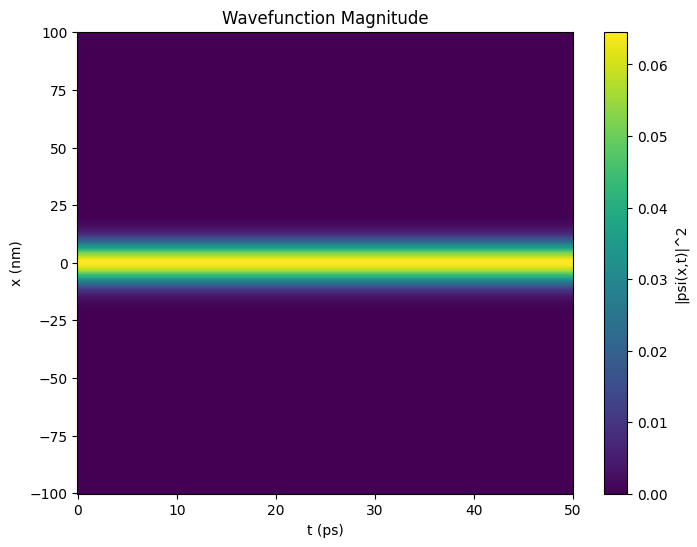

In [24]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(t_values, x_values, psi_sq, shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('t (ps)')
plt.ylabel('x (nm)')
plt.title('Wavefunction Magnitude')
plt.show()

# Testing

In [25]:
Nx = 400
Nt = 400

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [26]:
x_values_tf = tf.convert_to_tensor(x_values)
t_values_tf = tf.convert_to_tensor(t_values)

psi_real_pinn = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_pinn = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values_tf):
  for j, t in enumerate(t_values_tf):
    re, im = model(([x], [t]))
    psi_real_pinn[i, j] = re
    psi_img_pinn[i, j] = im

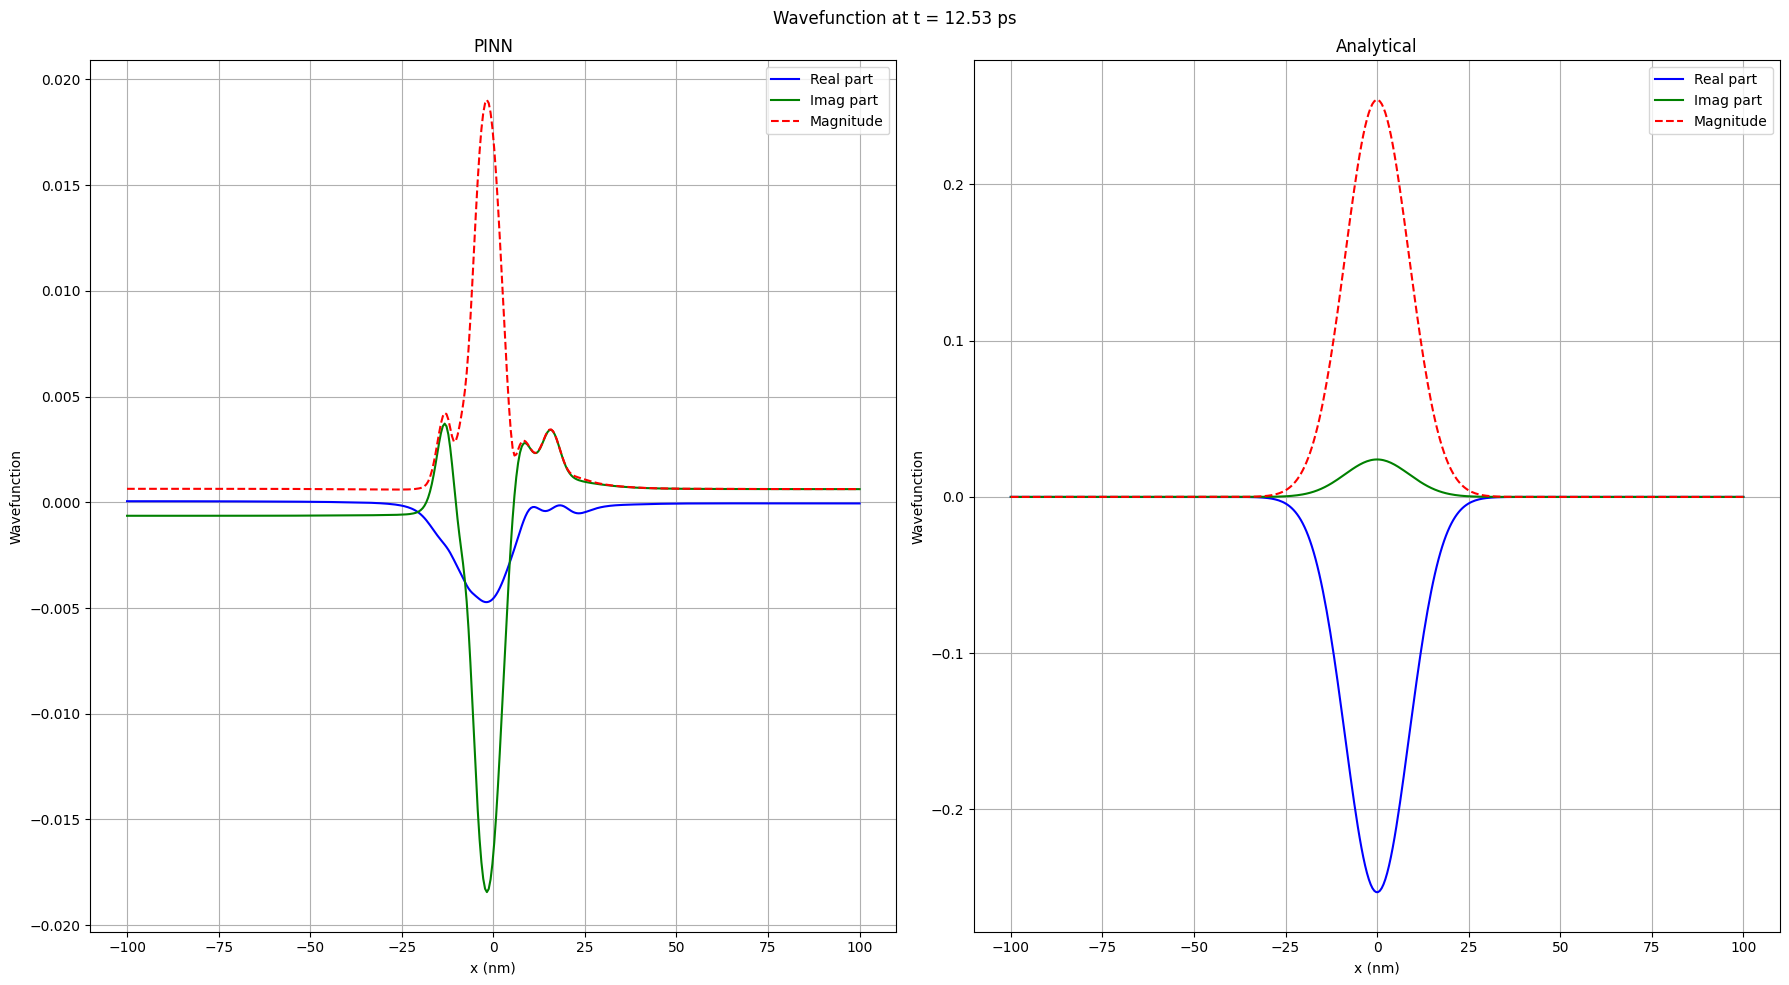

In [40]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_imag_slice_pinn = psi_img_pinn[:, time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_imag_slice_pinn ** 2)
psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical ** 2 + psi_img_slice_analytical ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
plt.suptitle(f"Wavefunction at t = {time_chosen:.2f} ps")

#pinn
axs[0].plot(x_values, psi_real_slice_pinn, label='Real part', color='blue')
axs[0].plot(x_values, psi_imag_slice_pinn, label='Imag part', color='green')
axs[0].plot(x_values, psi_mag_slice_pinn, '--', label='Magnitude', color='red')
axs[0].set_title(f'PINN')
axs[0].set_xlabel('x (nm)')
axs[0].set_ylabel('Wavefunction')
axs[0].legend()
axs[0].grid(True)

#analytical
axs[1].plot(x_values, psi_real_slice_analytical, label='Real part', color='blue')
axs[1].plot(x_values, psi_img_slice_analytical, label='Imag part', color='green')
axs[1].plot(x_values, psi_mag_slice_analytical, '--', label='Magnitude', color='red')
axs[1].set_title(f'Analytical')
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('Wavefunction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

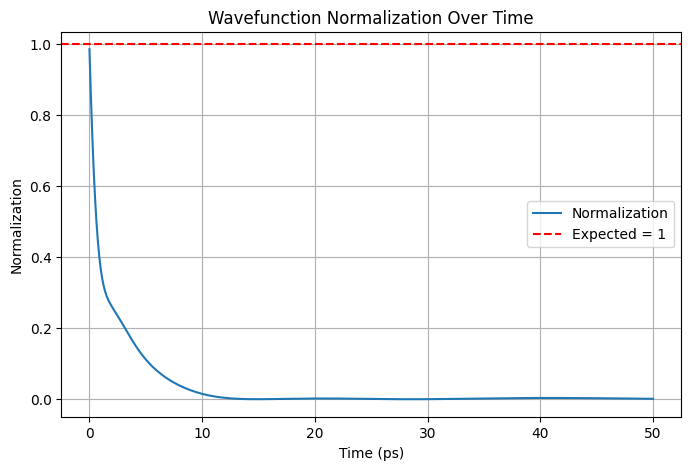

In [28]:
from scipy.integrate import simpson

norms = []

for i in range(400):
  psi_sq = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
  normalization = simpson(psi_sq, x_values)
  norms.append(normalization)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.show()

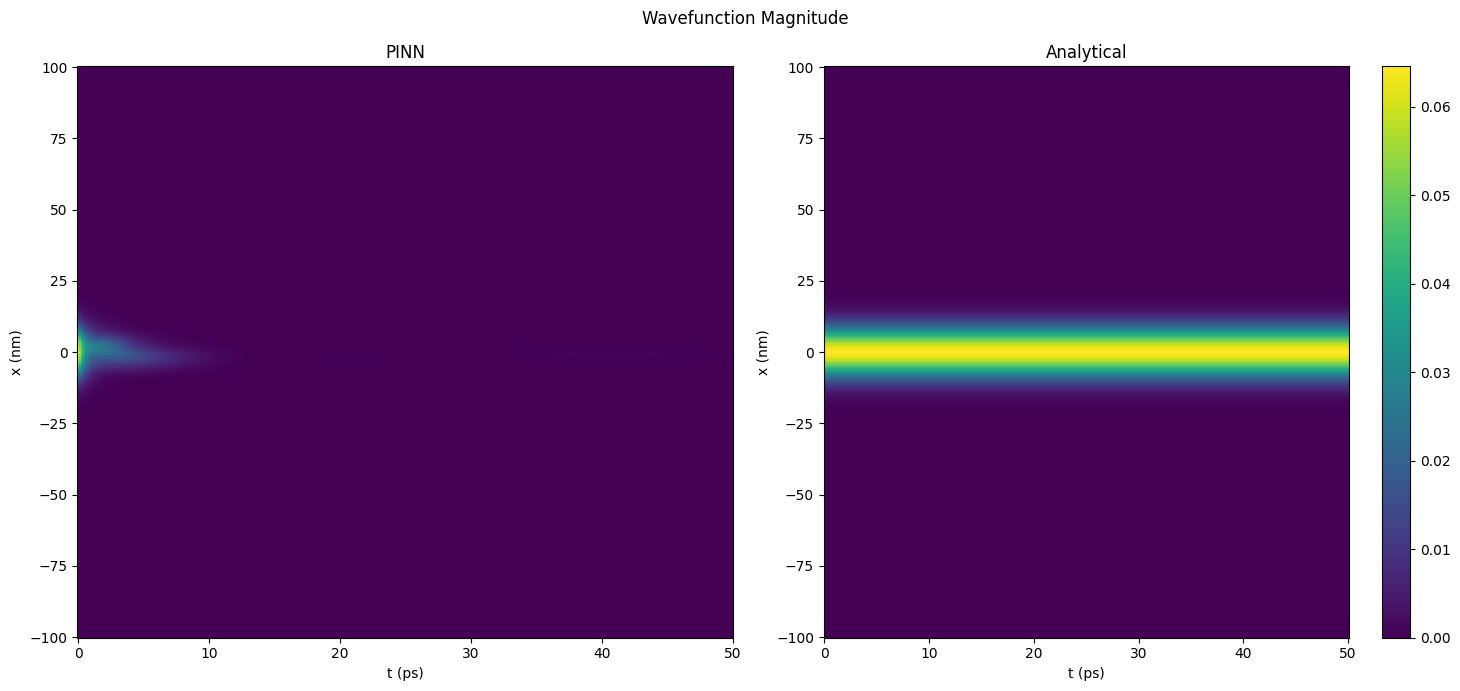

In [55]:
psi_sq_pinn = psi_real_pinn ** 2 + psi_img_pinn ** 2
psi_sq_analytical = psi_real_analytical ** 2 + psi_img_analytical ** 2

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle("Wavefunction Magnitude")

axs[0].pcolormesh(t_values, x_values, psi_sq_pinn, shading="auto")
# axs[0].set_colorbar(label='|psi(x,t)|^2')
axs[0].set_xlabel('t (ps)')
axs[0].set_ylabel('x (nm)')
axs[0].set_title('PINN')

im = axs[1].pcolormesh(t_values, x_values, psi_sq_analytical, shading="auto")
# axs[0].set_colorbar(label='|psi(x,t)|^2')
axs[1].set_xlabel('t (ps)')
axs[1].set_ylabel('x (nm)')
axs[1].set_title('Analytical')

fig.colorbar(mappable=im)
plt.tight_layout()
plt.show()

In [30]:
psi_analytical_mag = np.sqrt(psi_real_analytical ** 2 + psi_img_analytical ** 2)
psi_pinn_mag = np.sqrt(psi_real_pinn ** 2 + psi_img_pinn ** 2)

mse = (np.square(psi_analytical_mag - psi_pinn_mag)).mean()

print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 4.158e-03


# Testing 2

In [31]:
Nx = 400
Nt = 400

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [32]:
x_values_tf = tf.convert_to_tensor(x_values)
t_values_tf = tf.convert_to_tensor(t_values)

x_grid, t_grid = tf.meshgrid(x_values_tf, t_values_tf, indexing="ij")

x_flat = tf.reshape(x_grid, [-1])
t_flat = tf.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = tf.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = tf.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.numpy()
psi_img_pinn = psi_img_pinn.numpy()

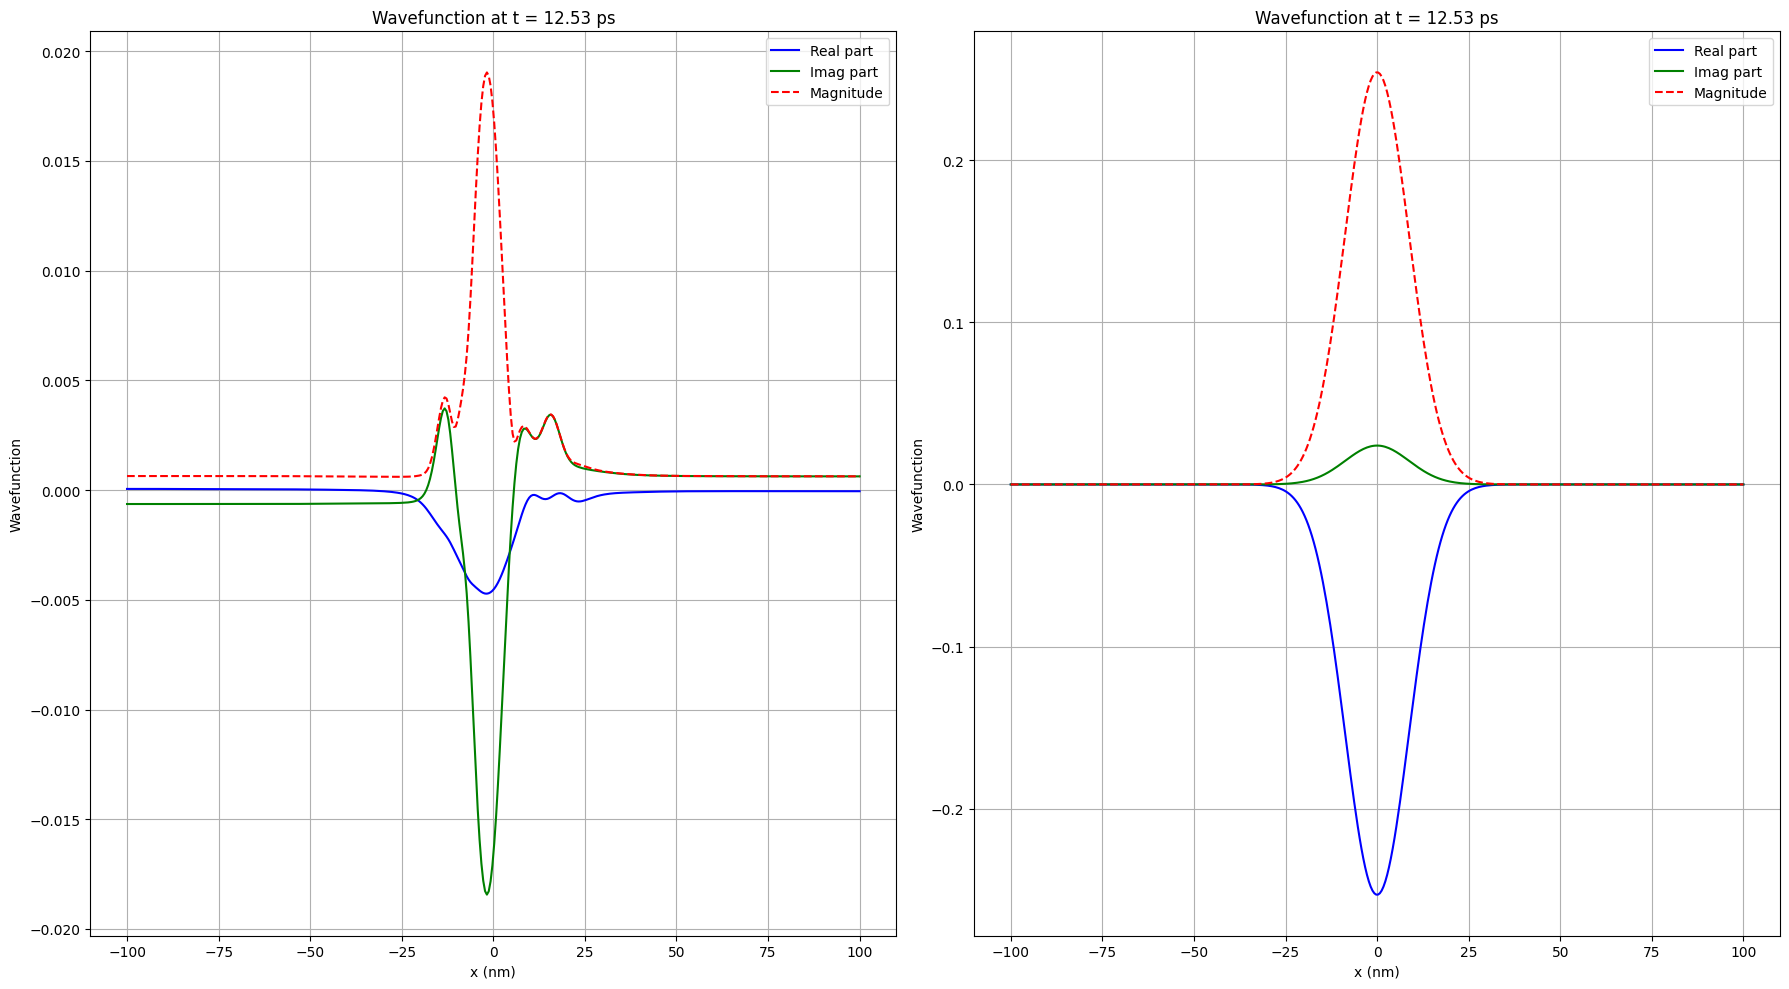

In [33]:
time_index = 100
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_imag_slice_pinn = psi_img_pinn[:, time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_imag_slice_pinn ** 2)
psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical ** 2 + psi_img_slice_analytical ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 10))

#pinn
axs[0].plot(x_values, psi_real_slice_pinn, label='Real part', color='blue')
axs[0].plot(x_values, psi_imag_slice_pinn, label='Imag part', color='green')
axs[0].plot(x_values, psi_mag_slice_pinn, '--', label='Magnitude', color='red')
axs[0].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[0].set_xlabel('x (nm)')
axs[0].set_ylabel('Wavefunction')
axs[0].legend()
axs[0].grid(True)

#analytical
axs[1].plot(x_values, psi_real_slice_analytical, label='Real part', color='blue')
axs[1].plot(x_values, psi_img_slice_analytical, label='Imag part', color='green')
axs[1].plot(x_values, psi_mag_slice_analytical, '--', label='Magnitude', color='red')
axs[1].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('Wavefunction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [34]:
psi_analytical_mag = psi_real_analytical ** 2 + psi_img_analytical ** 2
psi_pinn_mag = psi_real_pinn ** 2 + psi_img_pinn ** 2

mse = (np.square(psi_analytical_mag - psi_pinn_mag)).mean()

print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 2.125e-04
